
... ***CURRENTLY UNDER DEVELOPMENT*** ...


(1.9654277513278355, 23.069979283764873, 0.9848120914907972)

(1.6822637541157985, 23.404281383793084, 2.180792134236973)

(18.95, 4.142622950819671)

(0.306268186999902, 22.435145967527447, 2.146759336942524)

(0.29257280852089984, 4.520033480714275, 18.94233083990013, 6.923334720429665)

(-1.6540146774314168, -0.129743055502626, 48.577986086190776)

(4.383601935463517, 23.299144426270487, 3.8499137613564454)

(6.350246890758266e-08, 1.2475217319597367, 0.33816455980588733, 18.68523368196758, 1.956706123516529)

(0.1963561009204678, 22.211281711672076, 2.0809807607435284)

(5.506987453559015, 17.590111390531064, 0.9991994248469172)

(22.001363462951797, 1.9403082962240057)

(24.23485554340609, 2.204993446360673)

(0.21431564497493877, 12.516330563641468, 10.33830410030749)

(23.09262295081967, 2.2443681683984593)

(5.150009257465317, 0.10005714198099414, 18.849942857647974)



Text(0, 0.5, 'Frequency')

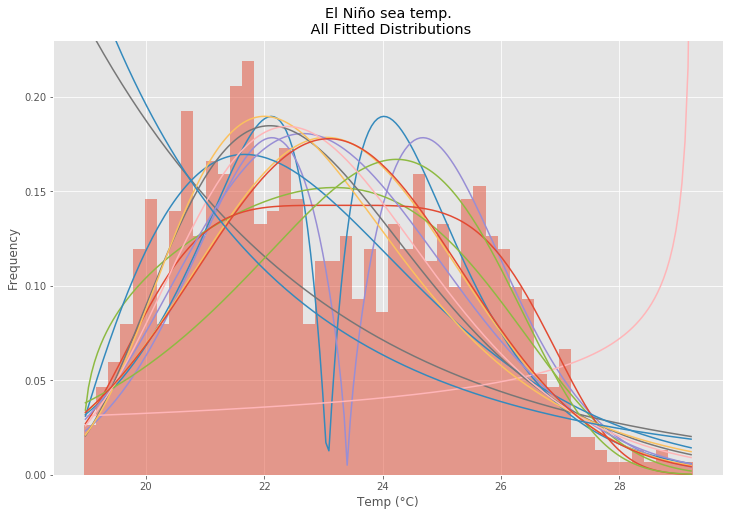

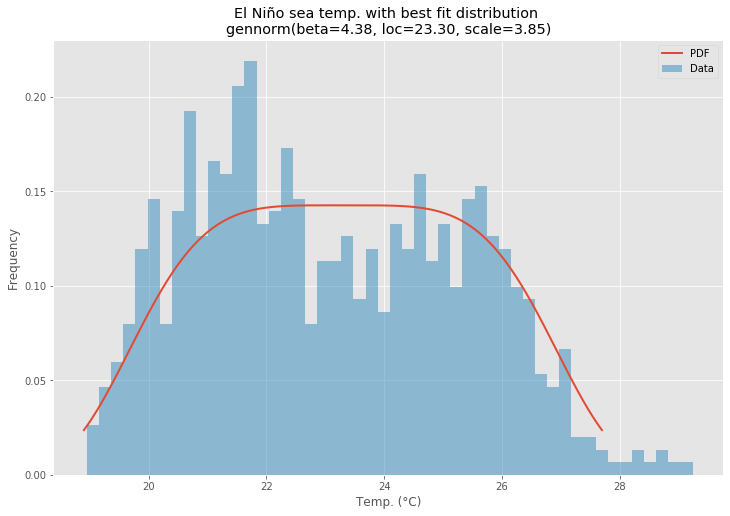

In [12]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.dgamma,st.dweibull,st.expon,st.exponnorm,st.exponweib,
        st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gamma,st.gumbel_r,
        st.gumbel_l,
        st.lognorm,
        st.norm,st.pareto
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        
        print(distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)
                print(params)
                print()

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5)
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')